In [1]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
! pip install en_ner_bionlp13cg_md


import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pydot
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers


from sklearn.decomposition import PCA

from collections import Counter


from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125.1 MB 43 kB/s 
     |████████████████████████████████| 6.0 MB 4.6 MB/s 
     |████████████████████████████████| 13.7 MB 29 kB/s 
     |████████████████████████████████| 671 kB 56.3 MB/s 
  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.4.0-py3-none-any.whl size=125679333 sha256=7db4247e1610af1c0d69f18153abfb5d69e571ff9cabf90aab740095ce79f76c
  Stored in directory: /root/.cache/pip/wheels/14/df/b7/7c9fcdc6696e8a2774b70e4729f18403285604c98718c584ec
Successfully built en-ner-bionlp13cg-md
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.2
    Uninstalling pydantic-1.10.2:
      Successfully uninstalled pydantic-1.10.2
  Attempting uninstall: thinc
 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv("mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
df=df[['transcription','medical_specialty']]
df.head()

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [4]:
df = df[df['medical_specialty'] != ' Surgery']
df = df[df['medical_specialty'] != ' SOAP / Chart / Progress Notes']
df = df[df['medical_specialty'] != ' Emergency Room Reports']
df = df[df['medical_specialty'] != ' Discharge Summary']
df = df[df['medical_specialty'] != ' Office Notes']
df = df[df['medical_specialty'] != ' General Medicine']
df = df[df['medical_specialty'] != ' Pain Management']

In [5]:
df.isna().sum()

transcription        16
medical_specialty     0
dtype: int64

In [6]:
df.dropna(axis=0,inplace=True)

In [7]:
counts = df['medical_specialty'].value_counts()

df = df[~df['medical_specialty'].isin(counts[counts < 240].index)]
df.head()

,transcription,medical_specialty
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary


In [8]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [9]:
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ',text)
    text = extra_symbol_remover.sub('',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))    
    return ' '.join(wordlist) 

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [11]:
df['transcription'] = df['transcription'].apply(clean_text)
df['transcription'] = df['transcription'].apply(lemmatize_text)

In [12]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
del feature_names[0:35]
print(feature_names)

['60', '6french', '70', '75', '80', '90', '92', '93', '95', '96', 'abc', 'abcd', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormality', 'abuse', 'according', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adenopathy', 'adequate', 'administered', 'admission', 'admitted', 'advanced', 'affect', 'age', 'ago', 'air', 'airway', 'alcohol', 'alert', 'alert oriented', 'allergic', 'allergy', 'allergy known', 'allergy known drug', 'anemia', 'anesthesia', 'anesthesia general', 'anesthetic', 'angiogram', 'angiography', 'ankle', 'anterior', 'anterior descending', 'antibiotic', 'anxiety', 'aorta', 'aortic', 'aortic valve', 'ap', 'apparently', 'appear', 'appearance', 'appeared', 'appears', 'applied', 'appropriate', 'approximately', 'area', 'arm', 'arterial', 'artery', 'artery disease', 'arthritis', 'asked', 'aspect', 'aspirin', 'assessment', 'associated', 'atraumatic', 'atrial', 'atrial fibrillatio

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
#Principal component analysis (PCA).
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['medical_specialty'].tolist()
category_list = df.medical_specialty.unique()

In [14]:
print(df['medical_specialty'])

3        Cardiovascular / Pulmonary
4        Cardiovascular / Pulmonary
7        Cardiovascular / Pulmonary
9        Cardiovascular / Pulmonary
11       Cardiovascular / Pulmonary
                   ...             
4972     Cardiovascular / Pulmonary
4973     Cardiovascular / Pulmonary
4974     Cardiovascular / Pulmonary
4975     Cardiovascular / Pulmonary
4976     Cardiovascular / Pulmonary
Name: medical_specialty, Length: 1515, dtype: object


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(df['transcription'].tolist(), df['medical_specialty'].tolist(),  stratify = df['medical_specialty'].tolist(), test_size=0.33,random_state=0)

x_train=np.asarray(X_train)
x_valid = np.array(X_valid)
x_test =np.asarray(df['transcription'].tolist())

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(df['medical_specialty'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((df['medical_specialty'],test_labels));

In [16]:
print(y_train[0:20])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[0:20])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[0:20])

[' Radiology', ' Cardiovascular / Pulmonary', ' Orthopedic', ' Consult - History and Phy.', ' Radiology', ' Orthopedic', ' Cardiovascular / Pulmonary', ' Cardiovascular / Pulmonary', ' Orthopedic', ' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Orthopedic', ' Orthopedic', ' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Orthopedic', ' Radiology', ' Consult - History and Phy.', ' Radiology', ' Cardiovascular / Pulmonary']
Text to number
[3 0 2 1 3 2 0 0 2 0 1 2 2 0 1 2 3 1 3 0]
Number to category
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [17]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1" #Creating embedding layer
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)



In [18]:
print(x_train[:1])
hub_layer(x_train[:1])

['cc paraplegia hx 32 rhf performing missionary work jos nigeria several year delivered 4th child vaginal delivery 4 10 97 delivery induced pitocin otherwise uncomplicated first 4 day postpartum noted clear liquid diarrhea without blood minor abdominal discomfort spontaneous resolved without medical treatment second week postpartum 45 day sinusitis purulent nasal discharge facial pain otherwise well 5 4 97 stationed rural area nigeria noted dull ache knee lateral patella proximal tibia bilaterally pain relieved massage seemed bothersome seated supine sensory loss time 5 6 97 awakened pain radiating knee anterior tibia next hour pain radiated circumferentially around calf involved sol foot posterior ble buttock rising bed became laborious task required assistance walk bathroom ibuprofen provided minimal analgesia evening sole one foot numb awoke next morning 5 9 97 pin needle sensation ble buttock given darvocet analgesia took airplane back larger city based one hour flight ble weakness

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 2.0663931 , -0.8010143 , -3.84755   , -1.3448297 ,  4.2780685 ,
        -4.3240547 , -5.3208895 , -0.490371  , -0.8092761 , -4.2623844 ,
        -1.8723013 , 10.11643   ,  0.9737524 , -4.2678657 ,  0.70083475,
         1.7452117 , -6.804348  , -2.2060795 ,  2.49989   , -1.5491278 ]],
      dtype=float32)>

In [19]:
model1 = tf.keras.Sequential()
model1.add(hub_layer)
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(30, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(4,activation='sigmoid',kernel_regularizer=regularizers.l2(0.05)))

model1.summary()
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                389380    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 30)                630       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 124       
                                                                 
Total params: 390,134
Trainable params: 390,134
Non-trainable params: 0
_________________________________________________________________


In [20]:
epochs = 60

# Fit the model using the train and test datasets.
#epoch : when the learning model tries to fit the data on the entire data you call it as an epoch. when we want to do it 60 times we put epoch as 60 
history1 = model1.fit(train_ds.shuffle(1000).batch(32),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(32),
                    verbose=1)

Epoch 1/60


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 [==============================] - 4s 40ms/step - loss: 6.1527 - categorical_accuracy: 0.2571 - val_loss: 3.0955 - val_categorical_accuracy: 0.3420
Epoch 2/60
32/32 [==============================] - 1s 26ms/step - loss: 4.6423 - categorical_accuracy: 0.2611 - val_loss: 2.7515 - val_categorical_accuracy: 0.3860
Epoch 3/60
32/32 [==============================] - 0s 15ms/step - loss: 4.0760 - categorical_accuracy: 0.3005 - val_loss: 2.5451 - val_categorical_accuracy: 0.4140
Epoch 4/60
32/32 [==============================] - 0s 14ms/step - loss: 3.3726 - categorical_accuracy: 0.3369 - val_loss: 2.4106 - val_categorical_accuracy: 0.4520
Epoch 5/60
32/32 [==============================] - 1s 16ms/step - loss: 3.0586 - categorical_accuracy: 0.3241 - val_loss: 2.3076 - val_categorical_accuracy: 0.4680
Epoch 6/60
32/32 [==============================] - 0s 14ms/step - loss: 2.8168 - categorical_accuracy: 0.3429 - val_loss: 2.2232 - val_categorical_accuracy: 0.4860
Epoch 7/60
32/32 [===

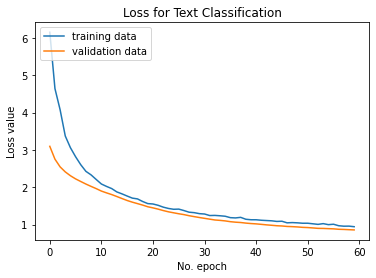

In [21]:
plt.plot(history1.history['loss'], label='training data')
plt.plot(history1.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [23]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# results = model1.evaluate(x_test, test_labels)
# print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = model1.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Evaluate on test data
Generate predictions for all samples
48/48 [==============================] - 1s 7ms/step
[[0.7410612  0.27061138 0.43982667 0.7013266 ]
 [0.77730805 0.24611342 0.4238744  0.7281937 ]
 [0.62648946 0.38134483 0.42566782 0.63038296]
 ...
 [0.71426886 0.85416055 0.20371145 0.11528943]
 [0.6399665  0.6336789  0.3011525  0.3875443 ]
 [0.6030382  0.8536716  0.21657476 0.22354214]]


In [24]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(x_test,test_labels)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = model1.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Evaluate on test data
48/48 [==============================] - 0s 5ms/step - loss: 0.8125 - categorical_accuracy: 0.7749
test loss, test acc: [0.8125209212303162, 0.774917483329773]
Generate predictions for all samples
48/48 [==============================] - 0s 5ms/step
[[0.7410612  0.27061138 0.43982667 0.7013266 ]
 [0.77730805 0.24611342 0.4238744  0.7281937 ]
 [0.62648946 0.38134483 0.42566782 0.63038296]
 ...
 [0.71426886 0.85416055 0.20371145 0.11528943]
 [0.6399665  0.6336789  0.3011525  0.3875443 ]
 [0.6030382  0.8536716  0.21657476 0.22354214]]


In [25]:
print(predict_results[:100])

[0 0 3 0 0 0 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 3 0 0 3 0 0 0 0 0 0
 0 2 2 3 0 1 0 0 3 3 3 0 1 3 3 2 3 0 2 3 2 2 3 3 3 3 0 3 3 2 3 3 0 0 3 3 3
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 2 2 3 2]


In [26]:
df['pred_medical_specialty']= predict_results

df['pred_medical_specialty'] = np.where((df.pred_medical_specialty ==  0), ' Cardiovascular / Pulmonary',df.pred_medical_specialty)

df['pred_medical_specialty'] = np.where((df.pred_medical_specialty == '1'),' Consult - History and Phy.',df.pred_medical_specialty)
df['pred_medical_specialty'] = np.where((df.pred_medical_specialty == '2'),' Orthopedic',df.pred_medical_specialty)
df['pred_medical_specialty'] = np.where((df.pred_medical_specialty == '3'),' Radiology',df.pred_medical_specialty)


In [27]:
from sklearn.metrics import classification_report
   
print(classification_report(df['medical_specialty'],df['pred_medical_specialty']))

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.78      0.67      0.72       371
 Consult - History and Phy.       0.78      0.94      0.85       516
                 Orthopedic       0.82      0.72      0.77       355
                  Radiology       0.69      0.68      0.69       273

                   accuracy                           0.77      1515
                  macro avg       0.77      0.75      0.76      1515
               weighted avg       0.78      0.77      0.77      1515

